# **Mask Face Detector**

## **Preperations**

### **General Imports**

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import argparse
import os
import shutil
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

KeyboardInterrupt: ignored

### **Consts declaration and preparations**

In [ ]:
LEARNING_RATE=0.0003
EPOCHS = 20
BATCH_SIZE = 8
WIDTH=224

mixed_images_path = "./Face Mask Dataset/"
mixed_images_train_path = mixed_images_path + "Train"
mixed_images_validation_path = mixed_images_path + "Validation"
mixed_images_test_path = mixed_images_path + "Test"

paired_images_path = "./pair_face_divided/"
paired_white_path = paired_images_path + "white_masks/"
paired_blue_path = paired_images_path + "blue_masks/"
paired_black_path = paired_images_path + "black_masks/"

combined_path = './combined_dataset/'

### **Data and Pre Proccessing**
Loading all data(all colors generated masks), pre proccessing it and adds augmentations

In [ ]:
# remvcing corrupted files
all_paths = [mixed_images_train_path, mixed_images_validation_path, mixed_images_test_path,
             paired_white_path, paired_blue_path, paired_black_path]
for path in all_paths:
    corrupted_folder_path = os.path.join(path, '.ipynb_checkpoints')
    if os.path.exists(corrupted_folder_path):
        shutil.rmtree(corrupted_folder_path)    

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)
combined_training_set = aug.flow_from_directory(mixed_images_train_path,
                                                 target_size = (WIDTH, WIDTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

combined_validation_set = validation_datagen.flow_from_directory(mixed_images_validation_path,
                                                 target_size = (WIDTH, WIDTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

combined_test_set = aug.flow_from_directory(mixed_images_test_path,
                                                 target_size = (WIDTH, WIDTH),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

## **Building the Model**
The functions that build the model's architecture

In [ ]:
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(WIDTH, WIDTH, 3)))
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
headModel = Flatten(name="flatten_end")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

## **Training the Model**


### **Training the Model**
Putting everything together - loading the dataset created and commiting the training

In [ ]:
# compile our model
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

callback = callbacks.EarlyStopping(monitor='loss', patience=3)
steps_per_epoch = len(training_set) 
validation_steps = len(validation_set)
H =model.fit(x = combined_training_set, validation_data = combined_validation_set,epochs=EPOCHS,steps_per_epoch=steps_per_epoch,validation_steps =validation_steps,shuffle=True, callbacks=[callback])
model.save('detector_model.h5', save_format="h5")

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
1250/1250 [==============================] - 91s 71ms/step - loss: 0.7034 - accuracy: 0.4647 - val_loss: 0.7031 - val_accuracy: 0.5437
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5029

### **Training Results**
Summarize of the model's training's results

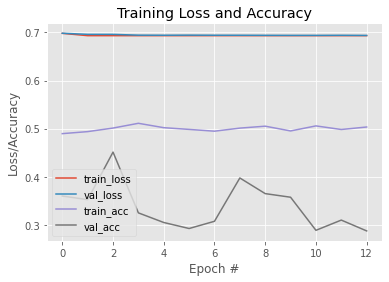

In [ ]:
%matplotlib inline

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


## **Models Architecture**
Displaying the model's architecture

In [ ]:
import visualkeras

visualkeras.layered_view(model, spacing=40)

## **Results**

### **Test Results**
Summarize of the model's test's results

In [ ]:
from keras.models import load_model
model = load_model('detector_model.h5')
predIdxs = model.predict(combined_test_set, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(combined_test_set.labels, predIdxs,
	target_names=combined_test_set.class_indices))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.50      0.99      0.66     11416
without_mask       0.53      0.01      0.02     11416

    accuracy                           0.50     22832
   macro avg       0.51      0.50      0.34     22832
weighted avg       0.51      0.50      0.34     22832



### **Making a Single Prediction**
Detecting all the masks on a single image

In [ ]:
%matplotlib inline
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [ ]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
# load the input image from disk, clone it, and grab the image spatial dimensions
detectorModel = load_model('detector_model.h5')
image = cv2.imread("detector-example.png")

orig = image.copy()
(h, w) = image.shape[:2]

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Detect the faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

print(len(faces))

3


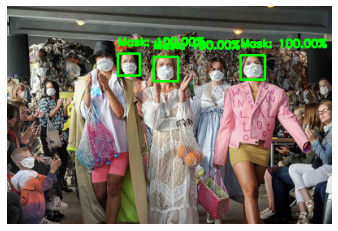

In [ ]:
from matplotlib import pyplot

# loop over the detections
for (x, y, w, h) in faces:

  # compute the (x, y)-coordinates of the bounding box for
  # the object
  (startX, startY, endX, endY) = (x, y, x+w, y+h)

  # extract the face ROI, convert it from BGR to RGB channel
  # ordering, resize it to 224x224, and preprocess it
  face = image[startY:endY, startX:endX]
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
  face = cv2.resize(face, (224, 224))
  face = img_to_array(face)
  face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)
  # pass the face through the model to determine if the face
  # has a mask or not
  (mask, withoutMask) = detectorModel.predict(face)[0]


  # determine the class label and color we'll use to draw
  # the bounding box and text
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
  # include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
  # display the label and bounding box rectangle on the output
  # frame
  cv2.putText(image, label, (startX, startY - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
# cv2.imshow("hey", image)
# cv2.waitKey(0)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pyplot.imshow(image)
pyplot.axis('off')
pyplot.show()